# Análise Preditiva Avançada

## Trabalho Individual
- **Curso:** FGV MBA - Business Analytics e Big Data
- **Disciplina:** Análise Preditiva Avançada
- **Professor:** Hitoshi Nagano e Gustavo Mirapalheta
- **Tarefa:** Trabalho Substitutivo de Prova
- **Link para este notebook:** [Kaggle](https://www.kaggle.com/danielferrazcampos/mnist-using-neural-network-random-forest-pt-br)

## Aluno
|Github|Kaggle|Nome
|---|---|---|---|---|
|<a href="https://github.com/DanielFCampos"><img src="https://avatars2.githubusercontent.com/u/31582602?s=460&v=4" title="DanielFCampos" width="40" height="40"></a>|<a href="https://www.kaggle.com/danielferrazcampos"><img src="https://storage.googleapis.com/kaggle-avatars/images/3508055-kg.png" title="DanielFCampos" width="40" height="40"></a>|Daniel Campos|

# Enunciado

- **Instruções** <br>
Turma: MSP 11924-TBABD-T1
Disciplina: Análise Preditiva Avançada (Professores Mirapalheta e Hitoshi)</br>

- **Questão 1:** <br>
Tomando por base o conjunto de dados MNIST, padrão do pacote Keras, defina e elabore uma rede neural sequencial, apresentando os formatos dos tensores de entrada e saída, bem como os tensores intermediários na rede. Treine e teste o modelo de rede neural sequencial desenvolvido, de forma que ele consiga atingir uma precisão de pelo menos 97% no teste, no reconhecimento das imagens de números escritos à mão livre. Compare o desempenho da rede neural no treino utilizando dados normalizados e não normalizados após 50 épocas de treino. Aumente o número de camadas internas da rede neural e determine se isto melhora ou não a qualidade dos resultados no teste. Qual o número de camadas que você consideraria ideal?</br>

- **Questão 2:** <br>
Resolva o mesmo problema da Questão 1 utilizando o algoritmo Random Forests. Tentem trabalhar a hiperparametrização para aumento do desempenho. Compare o seu melhor resultado com o resultado obtido na Questão 1 e comente.</br>

- **Data de Entrega** <br>
8 de junho de 2020 23:59</br>

# Resolução
### Carregar bibliotecas necessárias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from mlxtend.plotting import plot_confusion_matrix
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Carregar funções customizadas

In [2]:
def pred(model, x_test):
    pred_prob = model.predict(x_test)
    pred = np.argmax(pred_prob, axis = 1)
    return pred


def plot_confusion_mtx(model, x_test, y_test, plot_tittle):
    pred_prob = model.predict(x_test)
    pred = np.argmax(pred_prob, axis = 1)

    CM = confusion_matrix(y_test, pred)

    plot_confusion_matrix(conf_mat = CM, figsize = (16, 8))
    plt.title(plot_tittle)
    plt.xticks(range(10), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.yticks(range(10), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    plt.show()
    
def plot_confusion_mtx2(model, x_test, y_test, plot_tittle):
    pred= model.predict(x_test)

    CM = confusion_matrix(y_test, pred)

    plot_confusion_matrix(conf_mat = CM, figsize = (16, 8))
    plt.title(plot_tittle)
    plt.xticks(range(10), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.yticks(range(10), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    plt.show()

### Carregar e fazer o *reshape* do *dataset*

In [3]:
(trainX, trainy), (testX, testy) = mnist.load_data()
reshaped_trainX_unscaled = trainX.reshape([trainX.shape[0], -1]).astype('float32')
reshaped_testX_unscaled = testX.reshape([testX.shape[0], -1]).astype('float32')

scaler = MinMaxScaler()

reshaped_trainX = scaler.fit_transform(reshaped_trainX_unscaled)
reshaped_testX = scaler.fit_transform(reshaped_testX_unscaled)

encoded_trainy = to_categorical(trainy)
encoded_testy = to_categorical(testy)

print('\nFormato train dataset:\t%s\nTrain dataset reshaped:\t%s\nFormato labels dataset:\t%s' % (trainX.shape, reshaped_trainX.shape, trainy.shape))
print('\nFormato test dataset:\t%s\nTest dataset reshaped:\t%s\nFormato labels dataset:\t%s' % (testX.shape, reshaped_testX.shape, testy.shape))

11493376/11490434 [==============================] - 0s 0us/step

Formato train dataset:	(60000, 28, 28)
Train dataset reshaped:	(60000, 784)
Formato labels dataset:	(60000,)

Formato test dataset:	(10000, 28, 28)
Test dataset reshaped:	(10000, 784)
Formato labels dataset:	(10000,)


### Explorar conteúdo

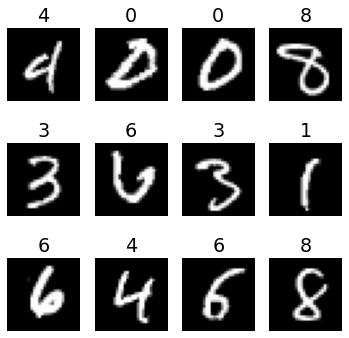

In [4]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize = (6, 6))
columns = 4
rows = 3

for i in range(1, columns * rows + 1):
    rnd = np.random.randint(0, len(trainX))
    img = trainX[rnd]  
    fig.add_subplot(rows, columns, i)
    plt.title(trainy[rnd])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

# Redes Neurais
### Rede Neural Simples com dados normalizados

In [5]:
NN = Sequential(name = 'Simple_NN')
NN.add(Dense(512, input_dim=784, activation='relu', name='input_layer'))
NN.add(Dense(10, activation='softmax', name='output_layer'))

print("input shape ",NN.input_shape)
print("output shape ",NN.output_shape)

input shape  (None, 784)
output shape  (None, 10)


In [6]:
NN.compile(loss=tf.keras.losses.categorical_crossentropy, 
           optimizer=tf.keras.optimizers.Adam(), 
           metrics=['accuracy'])

NN.summary()

Model: "Simple_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 512)               401920    
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [7]:
start = time.time()
history = NN.fit(reshaped_trainX, encoded_trainy, epochs=50, batch_size=64, verbose=0)

predicted = pred(NN, reshaped_testX)

elapsed_time = time.time() - start

NN_acc = accuracy_score(testy, predicted)
NN_time = elapsed_time

print("O treinamento levou %.0f segundos.\nAcurácia: %.4f" % (elapsed_time, NN_acc))

O treinamento levou 142 segundos.
Acurácia: 0.9835


In [8]:
print ("Reporte de classificação:\n")
print(classification_report(testy, predicted))

Reporte de classificação:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



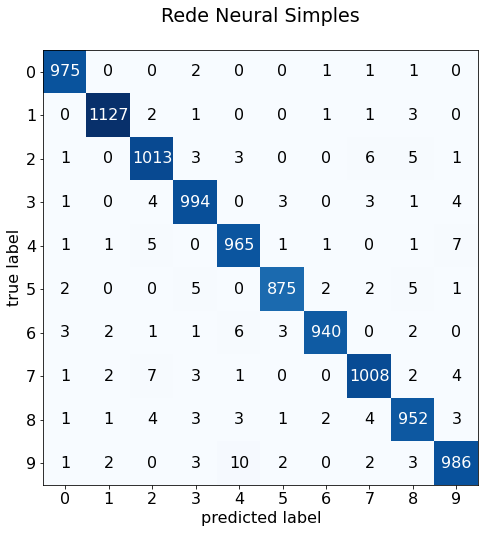

In [9]:
plot_confusion_mtx(NN, reshaped_testX, testy, 'Rede Neural Simples')

### Rede Neural Simples com dados não-normalizados

In [10]:
start = time.time()
history = NN.fit(reshaped_trainX_unscaled, encoded_trainy, epochs=50, batch_size=64, verbose=0)

predicted = pred(NN, reshaped_testX_unscaled)

elapsed_time = time.time() - start

NN_acc_ns = accuracy_score(testy, predicted)
NN_time_ns = elapsed_time

print("O treinamento levou %.0f segundos.\nAcurácia: %.4f" % (elapsed_time, NN_acc_ns))

O treinamento levou 146 segundos.
Acurácia: 0.9832


In [11]:
print ("Reporte de classificação:\n")
print(classification_report(testy, predicted))

Reporte de classificação:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



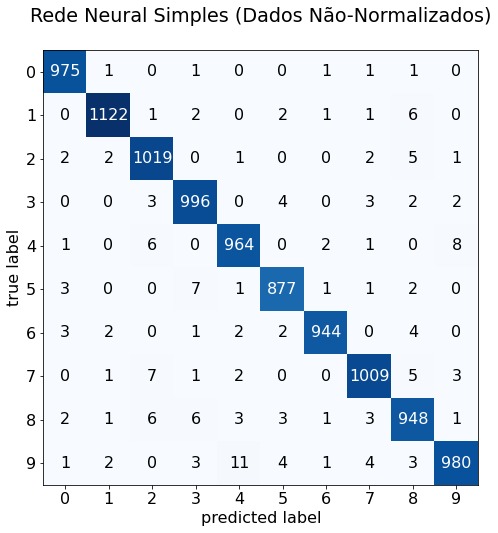

In [12]:
plot_confusion_mtx(NN, reshaped_testX, testy, 'Rede Neural Simples (Dados Não-Normalizados)')

### Rede Neural Profunda com dados normalizados 

In [13]:
DNN = Sequential(name = 'Deep_NN')
DNN.add(Dense(512, input_dim=784, activation='relu', name='input_layer'))
DNN.add(Dense(256, activation='relu', name='hidden_layer1'))
DNN.add(Dense(128, activation='relu', name='hidden_layer2'))
DNN.add(Dense(64, activation='relu', name='hidden_layer3'))
DNN.add(Dense(32, activation='relu', name='hidden_layer4'))
DNN.add(Dense(10, activation='softmax', name='output_layer'))

print("input shape ",DNN.input_shape)
print("output shape ",DNN.output_shape)

input shape  (None, 784)
output shape  (None, 10)


In [14]:
DNN.compile(loss=tf.keras.losses.categorical_crossentropy, 
            optimizer=tf.keras.optimizers.Adam(), 
            metrics=['accuracy'])

DNN.summary()

Model: "Deep_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 512)               401920    
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer4 (Dense)        (None, 32)                2080      
_________________________________________________________________
output_layer (Dense)         (None, 10)                330       
Total params: 576,810
Trainable params: 576,810
Non-trainable params: 0
_____________________________________________________

In [15]:
start = time.time()
history = DNN.fit(reshaped_trainX, encoded_trainy, epochs=50, batch_size=64, verbose=0)

predicted = pred(DNN, reshaped_testX)

elapsed_time = time.time() - start

DNN_acc = accuracy_score(testy, predicted)
DNN_time = elapsed_time

print("O treinamento levou %.0f segundos.\nAcurácia: %.4f" % (elapsed_time, DNN_acc))

O treinamento levou 230 segundos.
Acurácia: 0.9838


In [16]:
print ("Reporte de classificação:\n")
print(classification_report(testy, predicted))

Reporte de classificação:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.97      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



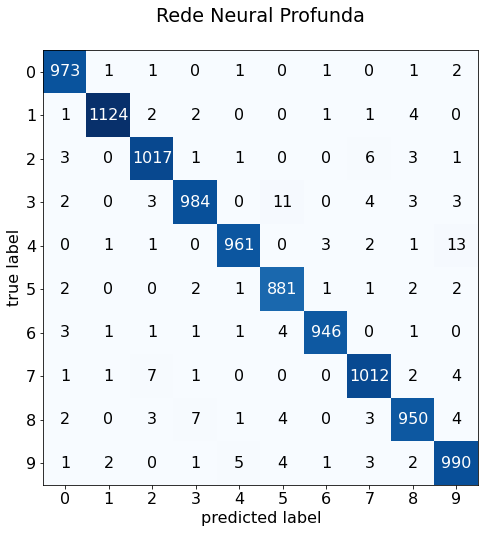

In [17]:
plot_confusion_mtx(DNN, reshaped_testX, testy, 'Rede Neural Profunda')

# Random Forest
### Classificador Random Forest com parâmetros basais

In [18]:
rf = RandomForestClassifier(max_depth = 5,
                            max_features = 5,
                            n_estimators = 50,
                            criterion = "entropy",
                            random_state = SEED, 
                            n_jobs=-1)

start = time.time()
rf.fit(reshaped_trainX, trainy)

predicted = rf.predict(reshaped_testX)
elapsed_time = time.time() - start

rf_acc = accuracy_score(testy, predicted)
rf_time = elapsed_time

print("O treinamento levou %.0f segundos para os parâmetros padrão.\nAcurácia: %.4f" % (elapsed_time, rf_acc))

O treinamento levou 1 segundos para os parâmetros padrão.
Acurácia: 0.8447


In [19]:
print ("Reporte de classificação:\n")
print(classification_report(testy, predicted))

Reporte de classificação:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       980
           1       0.75      0.99      0.86      1135
           2       0.92      0.83      0.87      1032
           3       0.76      0.86      0.81      1010
           4       0.89      0.81      0.85       982
           5       0.97      0.58      0.73       892
           6       0.87      0.90      0.88       958
           7       0.85      0.89      0.87      1028
           8       0.86      0.76      0.81       974
           9       0.82      0.82      0.82      1009

    accuracy                           0.84     10000
   macro avg       0.86      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



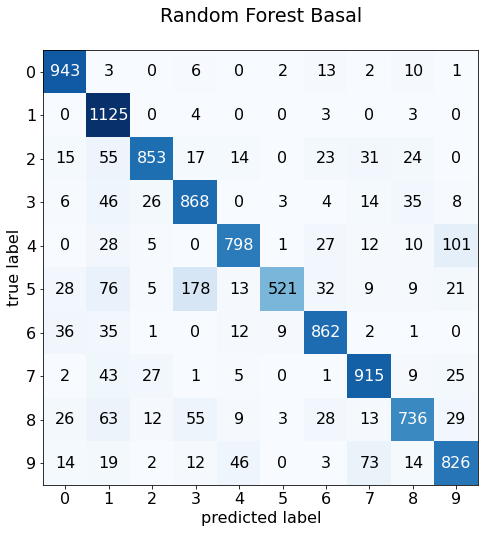

In [20]:
plot_confusion_mtx2(rf, reshaped_testX, testy, 'Random Forest Basal')

### Classificador Random Forest com parâmetros otimizados

In [21]:
space = {'max_depth': hp.quniform('max_depth', 1, 100, 1),
         'max_features': hp.quniform('max_features', 1, 50, 1),
         'n_estimators': hp.quniform('n_estimators', 25, 500, 5),
         'criterion': hp.choice('criterion', ["gini", "entropy"])}

In [22]:
def rf_tuning(space):
    
    global best_score, best_rf_model
    
    clf = RandomForestClassifier(max_depth = int(space['max_depth']),
                                 max_features = int(space['max_features']),
                                 n_estimators = int(space['n_estimators']), 
                                 criterion = space['criterion'], n_jobs=-1, random_state = SEED)
    
    clf.fit(reshaped_trainX, trainy)

    pred = clf.predict(reshaped_testX)
    accuracy = 1-accuracy_score(testy, pred)
    
    if (accuracy < best_score):
        best_score = accuracy
        best_rf_model = clf
    
    return {'loss': accuracy, 'status': STATUS_OK }

In [23]:
trials = Trials()
start = time.time()
neval = 50
best_score = 1.0
best_rf_model = []

best = fmin(fn = rf_tuning,
            space = space,
            algo = tpe.suggest,
            max_evals = neval,
            trials = trials,
            rstate = np.random.RandomState(SEED))

elapsed_time = time.time() - start

rf_optim_acc = (1-best_score)
rf_optim_time = elapsed_time

100%|██████████| 50/50 [49:09<00:00, 58.98s/trial, best loss: 0.027900000000000036]


In [24]:
print("A otimização de parâmetros levou %.0f segundos para %d rodadas.\nAcurácia: %.4f\n\nParâmetros ótimos encontrado:\n%s" % (elapsed_time, neval, rf_optim_acc, best))

A otimização de parâmetros levou 2949 segundos para 50 rodadas.
Acurácia: 0.9721

Parâmetros ótimos encontrado:
{'criterion': 0, 'max_depth': 70.0, 'max_features': 30.0, 'n_estimators': 365.0}


In [25]:
predicted = best_rf_model.predict(reshaped_testX)

In [26]:
print ("Reporte de classificação:\n")
print(classification_report(testy, predicted))

Reporte de classificação:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



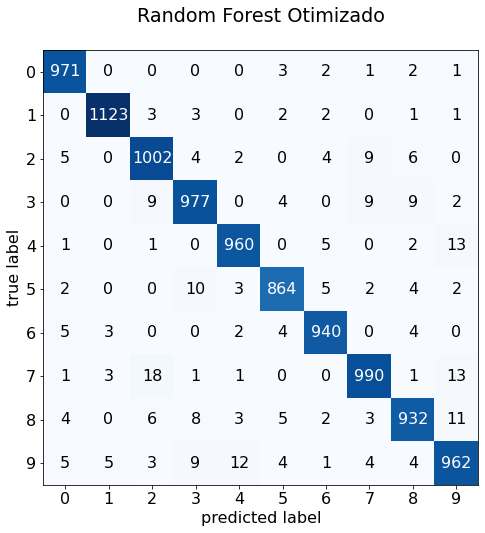

In [27]:
plot_confusion_mtx2(best_rf_model, reshaped_testX, testy, 'Random Forest Otimizado')

# Conclusão

In [28]:
print("Comparação das acurácias\n\nRede Neural Simples:\t\t\t%.2f%%\nRede Neural Simples (não norm.):\t%.2f%%\nRede Neural Profunda:\t\t\t%.2f%%\nRandom Forest Basal:\t\t\t%.2f%%\nRandom Forest Otimizado:\t\t%.2f%%" % (NN_acc*100, NN_acc_ns*100, DNN_acc*100, rf_acc*100, rf_optim_acc*100))
print("\nComparação dos tempos\n\nRede Neural Simples:\t\t\t%.0f s\nRede Neural Simples (não norm.):\t%.0f s\nRede Neural Profunda:\t\t\t%.0f s\nRandom Forest Basal:\t\t\t%.0f s\nRandom Forest Otimizado:\t\t%.0f s" % (NN_time, NN_time_ns, DNN_time, rf_time, rf_optim_time))

Comparação das acurácias

Rede Neural Simples:			98.35%
Rede Neural Simples (não norm.):	98.32%
Rede Neural Profunda:			98.38%
Random Forest Basal:			84.47%
Random Forest Otimizado:		97.21%

Comparação dos tempos

Rede Neural Simples:			142 s
Rede Neural Simples (não norm.):	146 s
Rede Neural Profunda:			230 s
Random Forest Basal:			1 s
Random Forest Otimizado:		2949 s


- **Respostas a Questão 1:** <br>
    * Tomando por base o conjunto de dados MNIST, padrão do pacote Keras, defina e elabore uma rede neural sequencial, apresentando os formatos dos tensores de entrada e saída, bem como os tensores intermediários na rede. <span style="color:red">Esta questão foi respondida com o uso dos comandos *input_shape*, *output_shape* e *summary* na grande seção **Redes Neurais**. Em todas as redes neurais criadas usamos um vetor unidimensional de 784 posições (correspondente ao números de pixels das imagens: 28x28) como entrada e 10 vetores de saída para a classificação *multi-label* do problema (números de 0 a 9). O comando *summary* mostra todas as camadas ocultas usadas (Rede Neural Simples com uma única camada com 512 neurônios + camadas de input/output e Rede Neural Profunda com 6 camadas com 512, 256, 128, 64, 32 e 16 neurônios cada + camadas de input/output).
    * Treine e teste o modelo de rede neural sequencial desenvolvido, de forma que ele consiga atingir uma precisão de pelo menos 97% no teste, no reconhecimento das imagens de números escritos à mão livre. Compare o desempenho da rede neural no treino utilizando dados normalizados e não normalizados após 50 épocas de treino. <span style="color:red">Os dados normalizados não apresentaram ganho/perda expressiva ao modelo apesar de esperarmos que houvesse uma melhora. Entretando, vale ressaltar que temos os dados todos em mesma escala (0 a 255) e o o maior prejuízo acontece quando temos *features* do modelo com mínimos e máximos muito diferentes entre si (fato tal que não acontece nesse exemplo).
    * Aumente o número de camadas internas da rede neural e determine se isto melhora ou não a qualidade dos resultados no teste. <span style="color:red">O número de camadas aumenta marginalmente a precisão do modelo com um custo computacional bastante maior (+35-40% no tempo de processamento para o nosso caso).
    * Qual o número de camadas que você consideraria ideal? <span style="color:red">Pensando em redes neurais não convolucionais, acredito que uma única camada resolve o problema com uma acurácia bastante satisfatória e com um tempo de processamento reduzido. Entretanto, é sabido que a adição de camadas convolucionais melhora bastante o resultado de redes neurais aplicadas a imagens, portanto, se fôssemos adicionar camadas, o ideal seria adicionar camadas convolucionais antes das camadas sequenciais não-convolucionadas.
<br><br>
- **Respostas a Questão 2:** <br>
    * Resolva o mesmo problema da Questão 1 utilizando o algoritmo Random Forests. Tentem trabalhar a hiperparametrização para aumento do desempenho. <span style="color:red">O modelo de Random Forest foi trabalhado de duas maneiras: parâmetros escolhidos manualmente e fazendo uma otimização Bayesiana dos parâmetros com o pacote hyperopt.
    * Compare o seu melhor resultado com o resultado obtido na Questão 1 e comente. <span style="color:red">Mesmo com os parâmetros ótimos obtidos pelo hyperopt, o modelo Random Forest não foi capaz de superar os modelos de redes neurais. Além disso, o tempo para a otimização foi muito maior do que o tempo de treinamento das redes neurais profundas deste exemplo. Entretanto, a simplicidade do modelo nos traz bons resultados com parâmetros bastante simples e tempo de treino curto, sendo uma alternativa viável para uma primeira abordagem ao problema.